In [1]:
from fore_utils import *

In [2]:
import torch
import torch.nn as nn
    
class TransformerModel_Point(nn.Module):
    def __init__(self, window_size: int = 24, variables: int = 6, spaces: int = 0, d_model=64, nhead=8, num_layers=8, output_dim: int = 12):
        super(TransformerModel_Point, self).__init__()

        input_dim = window_size * variables * spaces

        self.encoder = nn.Linear(input_dim, d_model)

        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)

        self.decoder = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        # print(x.shape)

        x = self.encoder(x)
        # print(x.shape)

        x = x.unsqueeze(1) 
        
        x = self.transformer_encoder(x)
        # print(x.shape)

        x = self.decoder(x.squeeze(1))
        # print(x.shape)
        
        return x
    

class MultivariateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(MultivariateLSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)

        lstm_out, _ = self.lstm(x)
        
        out = lstm_out[:, -1, :]
        
        out = self.fc(out)
        
        return out


class ImprovedMultivariateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(ImprovedMultivariateLSTM, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Adjust as needed

        lstm_out, _ = self.lstm(x)

        out = lstm_out[:, -1, :]
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out


class SimpleMLP(nn.Module):
    def __init__(self, window_size: int = 5, variables: int = 6, hidden_dim: int = 128, output_dim: int = 24, dropout_rate: float = 0.3):
        super(SimpleMLP, self).__init__()

        input_dim = window_size * variables  # Flattened input dimension
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output_layer(x)

        return x


class ComplexMLP(nn.Module):
    def __init__(self, window_size: int = 5, variables: int = 6,spaces:int= 0, hidden_dim: int = 128, output_dim: int = 24, dropout_rate: float = 0.3):
        super(ComplexMLP, self).__init__()

        input_dim = window_size * variables  # Flattened input dimension
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*3)
        self.fc4 = nn.Linear(hidden_dim*3, hidden_dim*2)
        self.fc5 = nn.Linear(hidden_dim*2, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output_layer(x)

        return x


class ComplexMLP_v1(nn.Module):
    def __init__(self, window_size: int = 5, variables: int = 6, spaces: int = 0,
                 hidden_dim: int = 128, output_dim: int = 24, dropout_rate: float = 0.1):
        super(ComplexMLP_v1, self).__init__()

        input_dim = window_size * variables  # Flattened input dimension
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim * 2)
        
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim * 3)
        self.bn3 = nn.BatchNorm1d(hidden_dim * 3)
        
        self.fc4 = nn.Linear(hidden_dim * 3, hidden_dim * 2)
        self.bn4 = nn.BatchNorm1d(hidden_dim * 2)
        
        self.fc5 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.bn5 = nn.BatchNorm1d(hidden_dim)
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        
        x = self.fc5(x)
        x = self.bn5(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        
        x = self.output_layer(x)
        
        return x


class EnsembleForecastingModel(nn.Module):
    def __init__(self, window_size: int = 5, variables: int = 6, spaces: int = 1, d_model=64, nhead=8, num_layers=8, output_dim: int = 24, hidden_dim: int = 128):
        super(EnsembleForecastingModel, self).__init__()
        
        # Initialize individual models
        self.transformer_model = TransformerModel_Point(window_size=window_size, 
                                                            variables=variables, 
                                                            spaces=spaces, 
                                                            d_model=d_model, 
                                                            nhead=nhead, 
                                                            num_layers=num_layers, 
                                                            output_dim=output_dim)

        self.lstm_model = MultivariateLSTM(input_size=window_size,
                         hidden_size=hidden_size,
                          output_size=output_dim,
                           num_layers=2,
                            dropout=0.2)
        self.mlp_model = SimpleMLP(window_size=window_size, 
                                    variables=variables, 
                                    hidden_dim=hidden_dim, 
                                    output_dim=output_dim)
        
        # Optional learnable weights for each model
        self.weights = nn.Parameter(torch.ones(3))  # One weight per model
    
    def forward(self, x):
        # Get predictions from each model
        transformer_output = self.transformer_model(x)
        lstm_output = self.lstm_model(x)
        mlp_output = self.mlp_model(x)
        
        # Stack outputs for weighted average
        outputs = torch.stack([transformer_output, lstm_output, mlp_output], dim=0)  # Shape: [3, batch_size, output_dim]
        
        # Normalize weights and compute weighted sum
        normalized_weights = torch.softmax(self.weights, dim=0)
        ensemble_output = (normalized_weights.view(-1, 1, 1) * outputs).sum(dim=0)  # Shape: [batch_size, output_dim]
        
        return ensemble_output


In [3]:
window_size = 24
steps = 24
spaces = 0
hidden_size = 8
batch_size = 32
n_heads = 4
num_layers = 8
intervals = 1
all_variables = False
series_target = True
lightning = True
verbose = True

config = {
    "hidden_layer_sizes": [hidden_size],
    "window_size" : [window_size],
    "step_size" : [steps],
    "spaces" : [spaces],
    "batch_size": [batch_size],
    "n_heads": [n_heads],
    "num_layers": [num_layers],
    "series_target": [series_target],
    "lightning": [lightning],
}

train_set = WeatherData(window_size=window_size, step_size=steps, set='train', spaces=spaces, intervals=intervals, lightning=lightning, all_variables=all_variables, series_target=series_target, verbose=verbose)
train_loader = DataLoader(train_set,
                           batch_size=batch_size, shuffle=True, drop_last=True)
    
val_set = WeatherData(window_size=window_size, step_size=steps, set='val', spaces=spaces, intervals=intervals, lightning=lightning,all_variables=all_variables, series_target=series_target, verbose=verbose)
val_loader = DataLoader(val_set,
                           batch_size=batch_size, shuffle=False, drop_last=True)


Details for train set:
Data from ['2018', '2019', '2020', '2021'] loaded
Features shape: torch.Size([35064, 6])
Targets shape: torch.Size([35064])
Longitudes: 18.3061580657959
Latitudes: -31.636999130249023
Details for val set:
Data from ['2022'] loaded
Features shape: torch.Size([8760, 6])
Targets shape: torch.Size([8760])
Longitudes: 18.3061580657959
Latitudes: -31.636999130249023


Input shape: torch.Size([32, 24, 6])
Target shape: torch.Size([32, 24])
Prediction shape: torch.Size([32, 24])


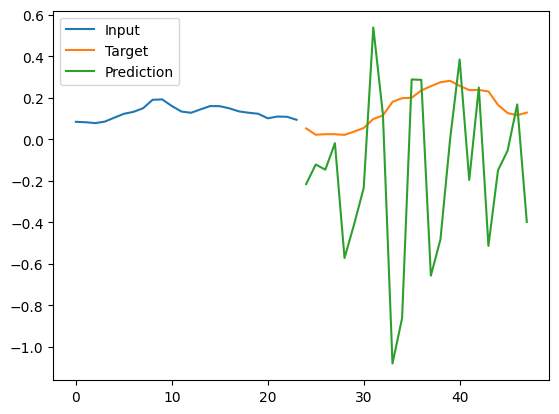

In [4]:
for batch in train_loader:
    x,b, y = batch
    break

num_layers = 8

# model = TransformerModel_Point(window_size=window_size, 
#                             variables=6, 
#                             spaces=1, 
#                             d_model=hidden_size, 
#                             nhead=n_heads, 
#                             num_layers=8, 
#                             output_dim=steps)

# model = ImprovedMultivariateLSTM(input_size=window_size,
#                                 hidden_size=hidden_size,
#                                 output_size=steps,
#                                 num_layers=num_layers,
#                                 dropout=0.2)

model = ComplexMLP_v1(window_size=window_size, 
                   variables=6, 
                   spaces=spaces,
                   hidden_dim=hidden_size, 
                   output_dim=steps,
                   dropout_rate=0)

# model = EnsembleForecastingModel(window_size=window_size,
#                                     variables=6,
#                                     spaces=1,
#                                     d_model=hidden_size,
#                                     nhead=n_heads,
#                                     num_layers=num_layers,
#                                     output_dim=steps,
#                                     hidden_dim=hidden_size)

model.to('cpu')

print('Input shape:', x.shape)
print('Target shape:', y.shape)


y_pred = model(x.float())
print('Prediction shape:', y_pred.shape)
# y_rollout = model(x.float())
# print('Rollout shape:', y_rollout.shape)


plt.plot(np.arange(window_size), b[0].detach().numpy(), label='Input')
plt.plot(np.arange(window_size,window_size+steps), y[0].detach().numpy(),  label='Target')
plt.plot(np.arange(window_size,window_size+steps), y_pred[0].detach().numpy(), label='Prediction')

plt.legend()
plt.show()

In [6]:
# Hyperparameters
n_epochs = 100
warmup_epochs = 10
initial_lr = 1e-4
early_stopping_patience = 5
checkpoint_path = f'best_mlp_{window_size}_{hidden_size}_{steps}.pth'

wandb.init(project="point-point-forecasts", name=f'model_mlp_{window_size}_{hidden_size}_{steps}', config=config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
                         
train_model(model, train_loader, val_loader, n_epochs=n_epochs, warmup_epochs=warmup_epochs,
            initial_lr=initial_lr, early_stopping_patience=early_stopping_patience, checkpoint_path=checkpoint_path, device=device,
            criterion=nn.L1Loss())



Epoch 0, Batch 0, Loss: 0.4137
Epoch 0, Batch 100, Loss: 0.3886
Epoch 0, Batch 200, Loss: 0.3901
Epoch 0, Batch 300, Loss: 0.3933
Epoch 0, Batch 400, Loss: 0.3813
Epoch 0, Batch 500, Loss: 0.3862
Epoch 0, Batch 600, Loss: 0.3772
Epoch 0, Batch 700, Loss: 0.3960
Epoch 0, Batch 800, Loss: 0.3832
Epoch 0, Batch 900, Loss: 0.3636
Epoch 0, Batch 1000, Loss: 0.3497
Epoch 0 Completed, Average Training Loss: 0.3782
Validation Loss after Epoch 0: 0.3941
Learning rate after Epoch 0: 0.000020
New best model saved with validation loss: 0.3941
Epoch 1, Batch 0, Loss: 0.3710
Epoch 1, Batch 100, Loss: 0.3645
Epoch 1, Batch 200, Loss: 0.3219
Epoch 1, Batch 300, Loss: 0.3358
Epoch 1, Batch 400, Loss: 0.3148
Epoch 1, Batch 500, Loss: 0.3112
Epoch 1, Batch 600, Loss: 0.3098
Epoch 1, Batch 700, Loss: 0.2947
Epoch 1, Batch 800, Loss: 0.2844
Epoch 1, Batch 900, Loss: 0.2797
Epoch 1, Batch 1000, Loss: 0.2799
Epoch 1 Completed, Average Training Loss: 0.3105
Validation Loss after Epoch 1: 0.3242
Learning rate 

In [7]:
test_loader = DataLoader(WeatherData(window_size=window_size, step_size=steps, set='test', spaces=spaces,intervals=intervals, lightning=True, verbose=True),
                            batch_size=batch_size, shuffle=False)

model.load_state_dict(torch.load(checkpoint_path))
model.eval()

test_loss = evaluate_model(model, test_loader, device)

print(f"Test loss: {test_loss}")

wandb.log({"test_loss": test_loss})

wandb.finish()

Details for test set:
Data from ['2023'] loaded
Features shape: torch.Size([8760, 6])
Targets shape: torch.Size([8760])
Longitudes: 18.3061580657959
Latitudes: -31.636999130249023
Test loss: 0.013374988613530802


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
learning_rate,▁▂▃▄▅▅▆▇████████████████▄▄▄▄▁▁▁
test_loss,▁
train_loss,█▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
learning_rate,3e-05
test_loss,0.01337
train_loss,0.06583
val_loss,0.08931


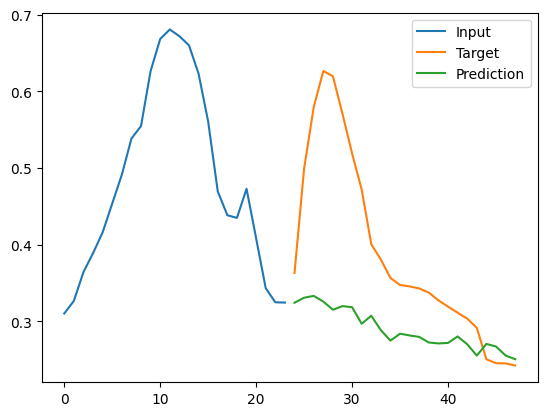

In [16]:
for batch in train_loader:
    x, b, y = batch
    break

model.to('cpu')

y_pred = model(x.float())

plt.plot(np.arange(window_size), b[0].detach().numpy(), label='Input')
plt.plot(np.arange(window_size,window_size+steps), y[0].detach().numpy(),  label='Target')
plt.plot(np.arange(window_size,window_size+steps), y_pred[0].detach().numpy(), label='Prediction')

plt.legend()
plt.show()
